# Using a Physics Informed Neural Network to Real World Data.

In this notebook, we use a PINN to preform an unsupervised measurement of the spring constant $k$ of a real world spring.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Experimental Data

The time series of the oscillation of a 300g mass on a spring was collected first hand using a ultrasonic sensor. The sensor was placed below the spring and recoreded the postion and velocity of the oscllation mass with a sampling rate of $20 Ss^{-1}$. The motion of the spring is govened by the following damped harmonic oscillator equation:

$$\frac{d^2x}{dt^2} + \frac{\mu}{m}\frac{dx}{dt} + \frac{k}{m}x=0$$

Where $x$ is the position of the mass $m$ relative to its equilibrium position, $\mu$ is the damping constant, and $k$ is the spring constant. The aim is to measure $\mu$ and $k$ of the spring by training a PINN on the time series.

$$x = x_c + e^{-\gamma t}\sin(\omega t + \psi)$$

The estimates for the parmeters are given as follows:

- $\gamma = (3.236\pm1.118) \times 10^{-3} s^{-1}$

- $\omega = 8.13336\pm1.71 \times 10^{-3} s^{-1}$

In [2]:
def sine_damp(t, A, x0, t0, w):
    return A * np.exp(-t/x0) * np.sin(np.pi * (t - t0) / w)

def damped_harmonic_oscillator(t, alpha=0.1, beta=2, x0=1, v0=1):
  gamma = alpha / 2
  assert(beta - gamma**2 > 0)

  omega = np.sqrt(beta - gamma**2)
  phi = np.arctan(-(v0 + gamma * x0) / (x0 * omega))
  A = x0 / np.cos(phi)

  return A * np.exp(-gamma * t) * np.cos(omega * t + phi)

Text(0, 0.5, 'x (m)')

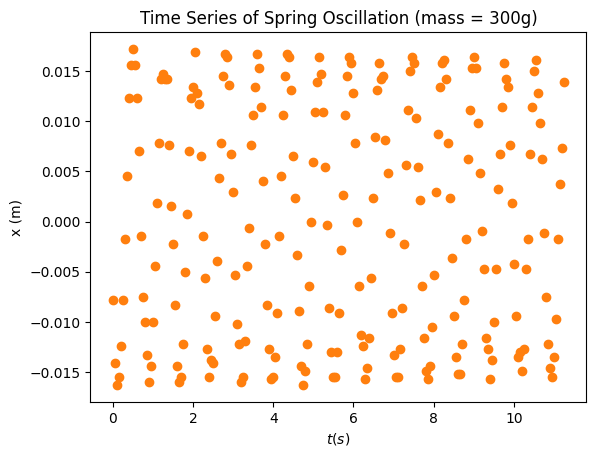

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Datasets/spring1_300g_1.csv'

with open(path) as file:
    data = np.genfromtxt(file ,delimiter=",", skip_header=1).T

t_data = data[0]
x_data = data[1]

# center the data
t_data -= t_data[0]
x_data -= x_data.mean()

plt.title("Time Series of Spring Oscillation (mass = 300g)")
plt.scatter(t_data, x_data, color="tab:orange")
plt.xlabel("$t (s)$")
plt.ylabel("x (m)")

# Nondimensionalisation

Before training a neural network on experimental data, it is always a good idea to normalise the data to avoid issues with vanishing and exploding gradients. Since there is a differential equation, the varibles $x$ and $t$ must be rescaled using a technique called nondimensionalisation. The nondimensionlisation scheme chosen for this case is given as follows:

$$\tilde{x} = \frac{x}{x_s}, \quad \tilde{t} = \frac{t}{t_s}$$

Subtituting into the damped harmonic oscillator equation gives:

$$ \ddot{\tilde{x}} + \frac{\mu t_s}{m}\dot{\tilde{x}} + \frac{k t_s^2}{m}\tilde{x} = 0 $$

Choosing the initial conditions such that:

$$ \tilde{x}(0) = \frac{x_0}{x_s}= 1, \quad \dot{\tilde{x}}(0) = \frac{t_sv_0}{x_s} = 1 $$

gives the following nondimensionalized initial value problem:

$$ \ddot{\tilde{x}} + \alpha\dot{\tilde{x}} + \beta\tilde{x} = 0, \quad \tilde{x}(0) = 1, \quad \dot{\tilde{x}}(0) = 1 $$

where:

$$\begin{align}
\alpha &= \frac{\mu x_0}{mv_0}, \quad \beta = \frac{k x_0^2}{m v_0^2} \\
\tilde{x} &= \frac{x}{x_0}, \qquad \tilde{t} = \frac{v_0 t}{x_0}
\end{align}$$




In [4]:
# rescales the input and output data according to the above nondimentionalisation scheme
def scale_data(t, x, v0):

    t_scaled = t * v0 / x[0]
    x_scaled = x / x[0]

    return t_scaled, x_scaled

0.00194165520281074 19.84547949513948
0.0005025965901058555 0.39891255502567097


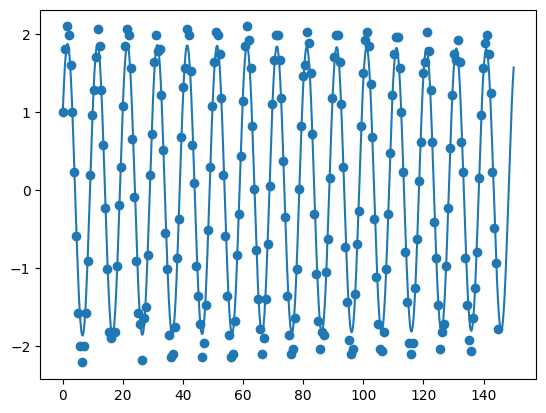

In [5]:
t_scaled, x_scaled = scale_data(t_data, x_data, data[2, 0])

mu = 2 * 0.3 / 309.0147
k = 0.3 * ((np.pi / 0.38626)**2 + (mu / (2 * 0.3))**2)

alpha = mu * x_data[0] / (0.3 * data[2, 0])
beta = k * x_data[0]**2 / (0.3 * data[2, 0]**2)

plt.scatter(t_scaled, x_scaled)
plt.plot(np.linspace(0, 150, 1000), damped_harmonic_oscillator(np.linspace(0, 150, 1000), alpha, beta))
print(mu, k)
print(alpha, beta)

# Motivation for Fourier Features

In [6]:
def build_NN(layers):
    NN = tf.keras.Sequential()

    NN.add(tf.keras.layers.Input((1, )))

    for neurons in layers:
        NN.add(tf.keras.layers.Dense(neurons, activation="tanh"))

    NN.add(tf.keras.layers.Dense(1))

    NN.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MSE
    )

    return NN

In [7]:
NN_3layers = build_NN(3 * [40])
NN_8layers = build_NN(8 * [40])

t_scaled = t_scaled.reshape((-1, 1))
x_scaled = x_scaled.reshape((-1, 1))

t_train = tf.constant(t_scaled, dtype=tf.float32)
x_train = tf.constant(x_scaled, dtype=tf.float32)

NN_3layers.fit(t_train, x_train, epochs=1000)
NN_8layers.fit(t_train, x_train, epochs=1000)

Epoch 1/1000
8/8 [==============================] - 2s 5ms/step - loss: 2.1750
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.2450
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.2022
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1208
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1867
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1262
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.1545
Epoch 8/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1005
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1581
Epoch 10/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1188
Epoch 11/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2305
Epoch 12/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2173
Epoch 13/1000
8/8 [==============================

32/32 [==============================] - 0s 6ms/step


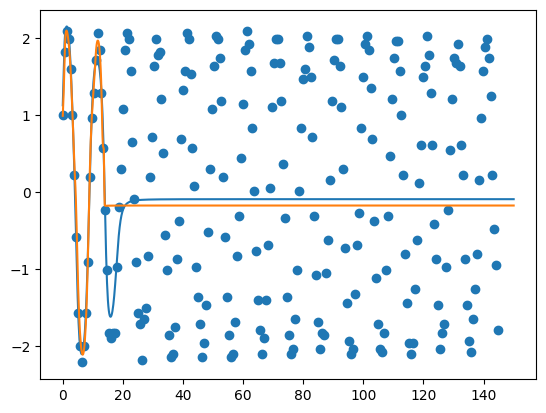

In [8]:
t_test = np.linspace(0, 150, 1000).reshape((-1, 1))
t_test = tf.constant(t_test, dtype=tf.float32)

x_pred_3layers = NN_3layers.predict(t_test)
x_pred_8layers = NN_8layers.predict(t_test)

plt.scatter(t_scaled, x_scaled)
plt.plot(t_test, x_pred_3layers)
plt.plot(t_test, x_pred_8layers)

In [9]:
class NN_fourier_features(tf.keras.Sequential):

    def __init__(self, num_features, stddev):
        super().__init__()
        self.B = tf.random.normal(shape=(1, num_features), stddev=stddev, dtype=tf.float32)

    def __call__(self, inputs, training=None, mask=None):
        fourier_features = self.__fourier_features(inputs)
        return super().__call__(fourier_features, training=training, mask=mask)

    def __fourier_features(self, inputs):
        cos_features = tf.math.cos(2 * np.pi * self.B * inputs)
        sin_features = tf.math.sin(2 * np.pi * self.B * inputs)
        return tf.concat([cos_features, sin_features], axis=1)


In [10]:
def build_NN_fourier_features(layers, num_features, stddev):

    NN = NN_fourier_features(num_features, stddev)

    NN.add(tf.keras.layers.Input((2 * num_features, )))

    for neurons in layers:
        NN.add(tf.keras.layers.Dense(neurons, activation="tanh"))

    NN.add(tf.keras.layers.Dense(1))

    return NN

In [11]:
NN_ff = build_NN_fourier_features(3 * [40], 10, 0.05)
optimizer = tf.keras.optimizers.Adam()

for epoch in range(1, 1000 + 1):
    with tf.GradientTape() as tape:
        x_pred = NN_ff(t_train)
        loss = tf.reduce_mean(tf.square(x_pred - x_train))

    gradients = tape.gradient(loss, NN_ff.trainable_variables)
    optimizer.apply_gradients(zip(gradients, NN_ff.trainable_variables))

    print(f"epoch: {epoch} loss: {loss}")

epoch: 1 loss: 2.511091709136963
epoch: 2 loss: 2.388333797454834
epoch: 3 loss: 2.287447690963745
epoch: 4 loss: 2.2060065269470215
epoch: 5 loss: 2.141214609146118
epoch: 6 loss: 2.0901496410369873
epoch: 7 loss: 2.050013542175293
epoch: 8 loss: 2.018305778503418
epoch: 9 loss: 1.992899775505066
epoch: 10 loss: 1.9720451831817627
epoch: 11 loss: 1.954331398010254
epoch: 12 loss: 1.9386413097381592
epoch: 13 loss: 1.9241136312484741
epoch: 14 loss: 1.9101065397262573
epoch: 15 loss: 1.8961637020111084
epoch: 16 loss: 1.8819854259490967
epoch: 17 loss: 1.867405891418457
epoch: 18 loss: 1.8523685932159424
epoch: 19 loss: 1.8369035720825195
epoch: 20 loss: 1.8210976123809814
epoch: 21 loss: 1.8050693273544312
epoch: 22 loss: 1.788939118385315
epoch: 23 loss: 1.772805094718933
epoch: 24 loss: 1.7567229270935059
epoch: 25 loss: 1.7406938076019287
epoch: 26 loss: 1.724664330482483
epoch: 27 loss: 1.7085360288619995
epoch: 28 loss: 1.6921840906143188
epoch: 29 loss: 1.6754802465438843
epoch:

32/32 [==============================] - 0s 3ms/step


Text(0, 0.5, 'x')

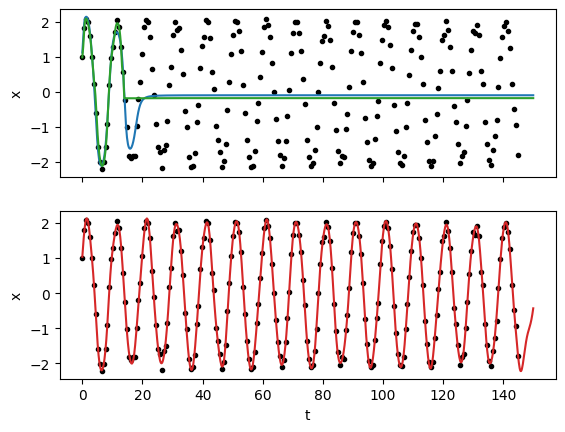

In [12]:
x_pred = NN_ff.predict(t_test)

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(t_scaled, x_scaled, color="k", marker=".")
ax[0].plot(t_test, x_pred_3layers, color="tab:blue", linestyle="-")
ax[0].plot(t_test, x_pred_8layers, color="tab:green", linestyle="-")
ax[0].set_ylabel("x")

ax[1].scatter(t_scaled, x_scaled, color="k", marker=".")
ax[1].plot(t_test, x_pred, color="tab:red")
ax[1].set_xlabel("t")
ax[1].set_ylabel("x")

In [13]:
fig.savefig("RFF_motivation.png")

In [14]:
class NN_discovery(NN_fourier_features):

    def __init__(self, num_features, stddev):
        super().__init__(num_features, stddev)
        self.alpha = tf.Variable(initial_value=1.0, trainable=True)
        self.beta = tf.Variable(initial_value=1.0, trainable=True)

In [15]:
class PINN_damped_harmonic_oscillator_discovery():

    def __init__(self, t, x, t_collocation, layers, num_features, stddev):

        # training data
        self.t = t
        self.x = x

        # collocation points
        self.t_collo = t_collocation

        # for calculating initial condition loss
        self.t0 = tf.constant(0., shape=(1,1))
        self.one = tf.constant(1., shape=(1,1))

        # neural network
        self.neural_net = self.initialize_neural_net(layers, num_features, stddev)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        self.history = []


    def initialize_neural_net(self, layers, num_features, stddev):
        neural_net = NN_discovery(num_features, stddev)

        # input layer
        neural_net.add(tf.keras.layers.Input(shape=(2 * num_features, )))

        # hidden layers
        for neurons in layers:
            neural_net.add(tf.keras.layers.Dense(neurons, activation='tanh'))

        # output layer
        neural_net.add(tf.keras.layers.Dense(1))

        return neural_net


    def predict(self, t):

        return self.neural_net(t)


    def train(self, epochs):

        for epoch in range(1, epochs - 1):
            with tf.GradientTape() as tape:
                loss = self.loss()

            gradients = tape.gradient(loss, self.neural_net.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.neural_net.trainable_variables))

            self.history.append(loss.numpy())
            print(f"epoch: {epoch} loss: {loss}")


    def loss(self):

        return self.data_loss() + self.physics_loss() #+ self.initial_condition_loss()


    def data_loss(self):

        x_pred = self.neural_net(self.t)
        loss = tf.reduce_mean(tf.square(x_pred - self.x))
        return loss


    def physics_loss(self):

        with tf.GradientTape() as tape1:
            tape1.watch(self.t_collo)

            with tf.GradientTape() as tape2:
                tape2.watch(self.t_collo)
                x = self.neural_net(self.t_collo)

            # first order derivative
            x_t = tape2.gradient(x, self.t_collo)

        # second order derivative
        x_tt = tape1.gradient(x_t, self.t_collo)

        # damped harmonic oscillator equation
        f = x_tt + self.neural_net.alpha * x_t + self.neural_net.beta * x
        loss = tf.reduce_mean(tf.square(f))

        return loss


    def initial_condition_loss(self):

        with tf.GradientTape() as tape:
            tape.watch(self.t0)
            x0 = self.neural_net(self.t0)

        v0 = tape.gradient(x0, self.t0)

        loss = tf.reduce_sum(tf.square(x0 - self.one) + tf.square(v0 - self.one))
        return loss

In [16]:
tf.random.set_seed(0)

t_collocation = np.linspace(0, 150, 10000).reshape((-1, 1))
t_collocation = tf.constant(t_collocation, dtype=tf.float32)

layers = 3 * [40]
PINN = PINN_damped_harmonic_oscillator_discovery(t_train, x_train, t_collocation, layers, num_features=10, stddev=0.05)

In [17]:
PINN.train(5_000)

epoch: 1 loss: 2.2599196434020996
epoch: 2 loss: 2.2224671840667725
epoch: 3 loss: 2.1918673515319824
epoch: 4 loss: 2.1672182083129883
epoch: 5 loss: 2.1474449634552
epoch: 6 loss: 2.131368398666382
epoch: 7 loss: 2.11789608001709
epoch: 8 loss: 2.1061606407165527
epoch: 9 loss: 2.0955498218536377
epoch: 10 loss: 2.0856714248657227
epoch: 11 loss: 2.0762946605682373
epoch: 12 loss: 2.067286252975464
epoch: 13 loss: 2.058561325073242
epoch: 14 loss: 2.0500500202178955
epoch: 15 loss: 2.041680097579956
epoch: 16 loss: 2.0333714485168457
epoch: 17 loss: 2.0250444412231445
epoch: 18 loss: 2.0166265964508057
epoch: 19 loss: 2.0080649852752686
epoch: 20 loss: 1.999330997467041
epoch: 21 loss: 1.9904241561889648
epoch: 22 loss: 1.9813659191131592
epoch: 23 loss: 1.9721943140029907
epoch: 24 loss: 1.962952971458435
epoch: 25 loss: 1.9536848068237305
epoch: 26 loss: 1.9444228410720825
epoch: 27 loss: 1.935188889503479
epoch: 28 loss: 1.925990104675293
epoch: 29 loss: 1.9168214797973633
epoch: 

In [18]:
print(abs(PINN.neural_net.alpha.numpy() - alpha) / alpha)

0.6731356689549298


In [19]:
print(abs(PINN.neural_net.beta.numpy() - beta) / beta)

0.0018699489729143927


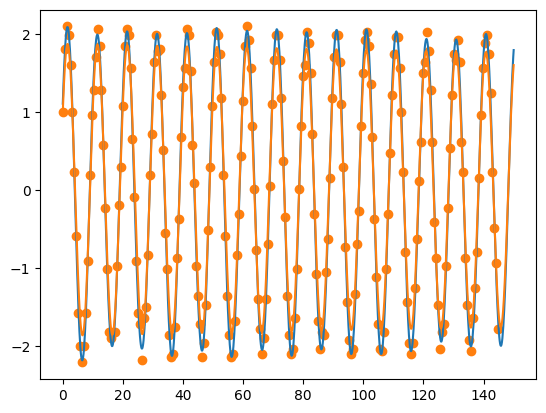

In [20]:
x_pred = PINN.predict(t_test)

plt.plot(t_test, x_pred)
plt.scatter(t_scaled, x_scaled, color="tab:orange")
plt.plot(t_collocation, damped_harmonic_oscillator(t_collocation, PINN.neural_net.alpha, PINN.neural_net.beta))

In [39]:
mu_discovered = PINN.neural_net.alpha * 0.3 * data[2, 0] / x_data[0]
k_discovered = PINN.neural_net.beta * 0.3 * data[2, 0]**2 / (x_data[0]**2)

print(mu_discovered, k_discovered)

tf.Tensor(0.0032486527, shape=(), dtype=float32) tf.Tensor(19.88259, shape=(), dtype=float32)


Text(0, 0.5, '$x\\;(m)$')

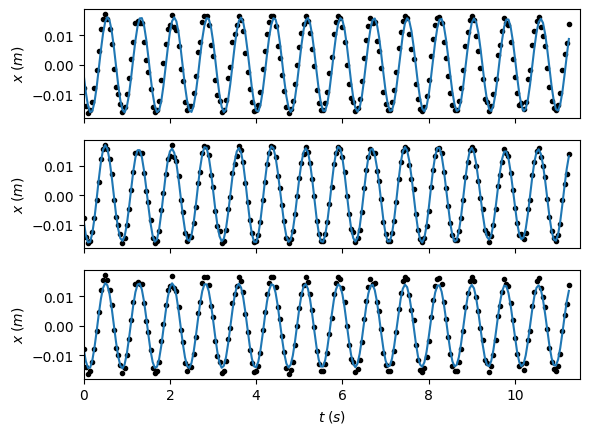

In [51]:
t_test = t_data.reshape((-1, 1))
x_discovered = damped_harmonic_oscillator(t_test, mu_discovered/0.3, k_discovered/0.3, x0=x_data[0], v0=data[2,0])
x_fit = sine_damp(t_test, A=0.01619, x0=309.0147, t0=0.36134, w=0.38626)

t_test = tf.constant(t_test, dtype=tf.float32)
x_pred = PINN.predict(t_test* data[2,0] / x_data[0]) * x_data[0]

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].scatter(t_data, x_data, color="k", marker=".")
ax[0].plot(t_test, x_fit)
ax[0].set_ylabel("$x\;(m)$")

ax[1].scatter(t_data, x_data, color="k", marker=".")
ax[1].plot(t_test, x_pred)
ax[1].set_ylabel("$x\;(m)$")

ax[2].scatter(t_data, x_data, color="k", marker=".")
ax[2].plot(t_test, x_discovered)
ax[2].set_xlim(0, 11.5)
ax[2].set_xlabel("$t\;(s)$")
ax[2].set_ylabel("$x\;(m)$")

In [52]:
fig.savefig("experiment_result.png")

In [55]:
def relative_error(x_pred, x_true):
    return tf.math.sqrt(tf.reduce_sum(tf.square(x_pred - x_true))) / tf.math.sqrt(tf.reduce_sum(tf.square(x_true)))

#x_fit = tf.constant(x_fit.reshape(-1, 1), dtype=tf.float32)
#x_discovered = tf.constant(x_discovered.reshape(-1, 1), dtype=tf.float32)
#x_data = tf.constant(x_data.reshape((-1, 1)), dtype = tf.float32)


print(f"Sine Damp Fit: {relative_error(x_fit, x_data)}")
print(f"PINN: {relative_error(x_pred, x_data)}")
print(f"Discovered Equation: {relative_error(x_discovered, x_data)}")

PINN: 0.41175147891044617
PINN: 0.06812771409749985
Discovered Equation: 0.1425301879644394
